In [1]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#for work with your data see section "control variables"
#variable "csv_custom" contains path to file with formulas
#formulas MUST NOT have these elements for correctly work of neural netiwk : He, Ne, Ar, Kr, Xe, Pm, Po, At, Rn
#order of elements in formula is NOT important. Example: Ba0.2La1.8Cu1O4 and Ba0.2O4Cu1La1.8 will give same results
#variable "csv_chemestry_table" contains chemestry table with parametrs of elements
#variable "rows" contains formulas in text format
#variable "fromulas_processed" contains processed formulas from variable "rows" for neural networks
#variable "predicted" is output variable with critical temperatures
#variable "target_size" is maximum numbers of element in formula. For my network target_size=10  
#variable "num_elements" is number of parametrs of chemestry element in formula. In my cas it is 17: 16 chemesetry parametrs and 1 formula coefficient
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#init libs
import math
import csv
import numpy as np
from numpy import loadtxt
from tensorflow.python.keras import  Model
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import model_from_json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K

In [2]:
#this function separate text and numbers(int and float)
def seperate_string_number(string):
    previous_character = string[0]
    groups = []
    newword = string[0]
    for x, i in enumerate(string[1:]):
        if i.isalpha() and previous_character.isalpha():
            newword += i
        elif i.isnumeric() and previous_character.isnumeric():
            newword += i
        else:
            groups.append(newword)
            newword = i

        previous_character = i

        if x == len(string) - 2:
            groups.append(newword)
            newword = ''
    buf=[]       
    next_idx=0
    for i in range(len(groups)):
        if i<len(groups)-1:
            if next_idx==i and groups[i+1]!=".":
                buf.append(groups[i])
                next_idx=next_idx+1
            if next_idx==i and  groups[i+1]==".":
                b_str=groups[i]+groups[i+1]+groups[i+2]
                buf.append(b_str)
                next_idx=i+3
        if i==len(groups)-1:
            if groups[i-1]!=".":
                buf.append(groups[i])        
    return buf
#example
str_0='aaaaa1.07in2.0fsafa124wt104.0001AA'
example_Str=seperate_string_number(str_0)
print(str_0)
print(example_Str)

aaaaa1.07in2.0fsafa124wt104.0001AA
['aaaaa', '1.07', 'in', '2.0', 'fsafa', '124', 'wt', '104.0001', 'AA']


In [3]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#control variables
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



#file with formulas
csv_custom=open('processed_data/formulas_example.txt', newline='')
reader_custom = csv.reader(csv_custom, delimiter=',', quotechar='|')



#adapted periodic table for neural network (DO NOT CHANGE IT)
csv_chemestry_table=open('processed_data/PTE_adapted.txt', newline='')
reader_chemestry_table = csv.reader(csv_chemestry_table, delimiter=',', quotechar='|')
#
target_size=10#num of position for elements
num_elements=17# params of element in formula


In [4]:

#reading rows from txt files
#reading formulas
rows=[]
nums_custom_formulas=0
read_it=True

while(read_it==True):
    try:
        read_row = next(reader_custom)
        rows.append(read_row)
        nums_custom_formulas=nums_custom_formulas+1
    except StopIteration:
        read_it=False
processed_rows=[]
for i in range(len(rows)):
    buf=seperate_string_number(rows[i][0])
    processed_rows.append(buf)

#reading chemestry table    
next(reader_chemestry_table)#drop headers
elements=[]
for i in range(86):
    read_row = next(reader_chemestry_table)
    for j in range(len(read_row)):
        read_row[j]=float(read_row[j])
    elements.append(read_row)


In [5]:
#order of elements
element_names=["H","He","Li","Be","B","C","N", "O","F", "Ne",
       "Na","Mg","Al","Si","P","S", "Cl","Ar", 
       "K","Ca","Sc","Ti","V","Cr","Mn","Fe", "Co","Ni", "Cu","Zn","Ga","Ge","As","Se","Br","Kr", 
       "Rb","Sr", "Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd", "Ag","Cd", "In","Sn","Sb","Te","I","Xe",
       "Cs","Ba", "La",
       "Ce", "Pr","Nd","Pm", "Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm", "Yb","Lu",
       "Hf","Ta", "W","Re","Os","Ir","Pt","Au","Hg","Ti", "Pb","Bi", "Po","At","Rn"
      ]
#formulas processing. stage1
#transform formulas from text to set of parametrs
formulas=[]
for i in range(len(processed_rows)):#formulas
    elem_buf=[]
    order=[]
    for j in range(len(processed_rows[i])):#elements
        
        for k in range(len(element_names)):#parametrs
            if processed_rows[i][j]==element_names[k]:
                order.append(k)
                buf=[]
                if j!=len(processed_rows[i])-1:
                    buf.append(float(processed_rows[i][j+1]))#coefficient
                else:
                    buf.append(float(1))#
                for f in range(len(elements[85])):
                    buf.append(float(elements[k][f]))
                buf=np.asarray(buf)
                elem_buf.append(buf)
    #sort by atomic number
    sorted_elem_buf=[]
    for i in range(len(order)):
        min_index = order.index(min(order))
        sorted_elem_buf.append(elem_buf[min_index])
        order[min_index]=999
    sorted_elem_buf=np.asarray(sorted_elem_buf)
    
    formulas.append(sorted_elem_buf)#elem_buf is transformed formula

formulas=np.asarray(formulas)    

In [6]:
#formulas processing. stage2 
#expansion formulas to size 10*17. 10*17 - size of neural network input. 
#10 elements in formula, every element has 16 parametrs and 1 coefficient
add_arr=[]# herea will be abstract element. all parametrs of its is zero
for i in range(num_elements):
    add_arr.append(0)
add_arr=np.asarray(add_arr)


fromulas_processed=[]
for i in range(formulas.shape[0]):

    dist=target_size-formulas[i].shape[0]
    buf1=[]
    
    if dist>0:
        for j in range(dist):
            buf1.append(add_arr)
    for j in range(formulas[i].shape[0]):
        buf1.append(formulas[i][j])
    buf1=np.asarray(buf1)
    fromulas_processed.append(buf1)
    
fromulas_processed=np.asarray(fromulas_processed)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Done
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 10, 17)]     0                                            
__________________________________________________________________________________________________
model_75 (Model)                (None, 1)            129857      input_9[0][0]                    
__________________________________________________

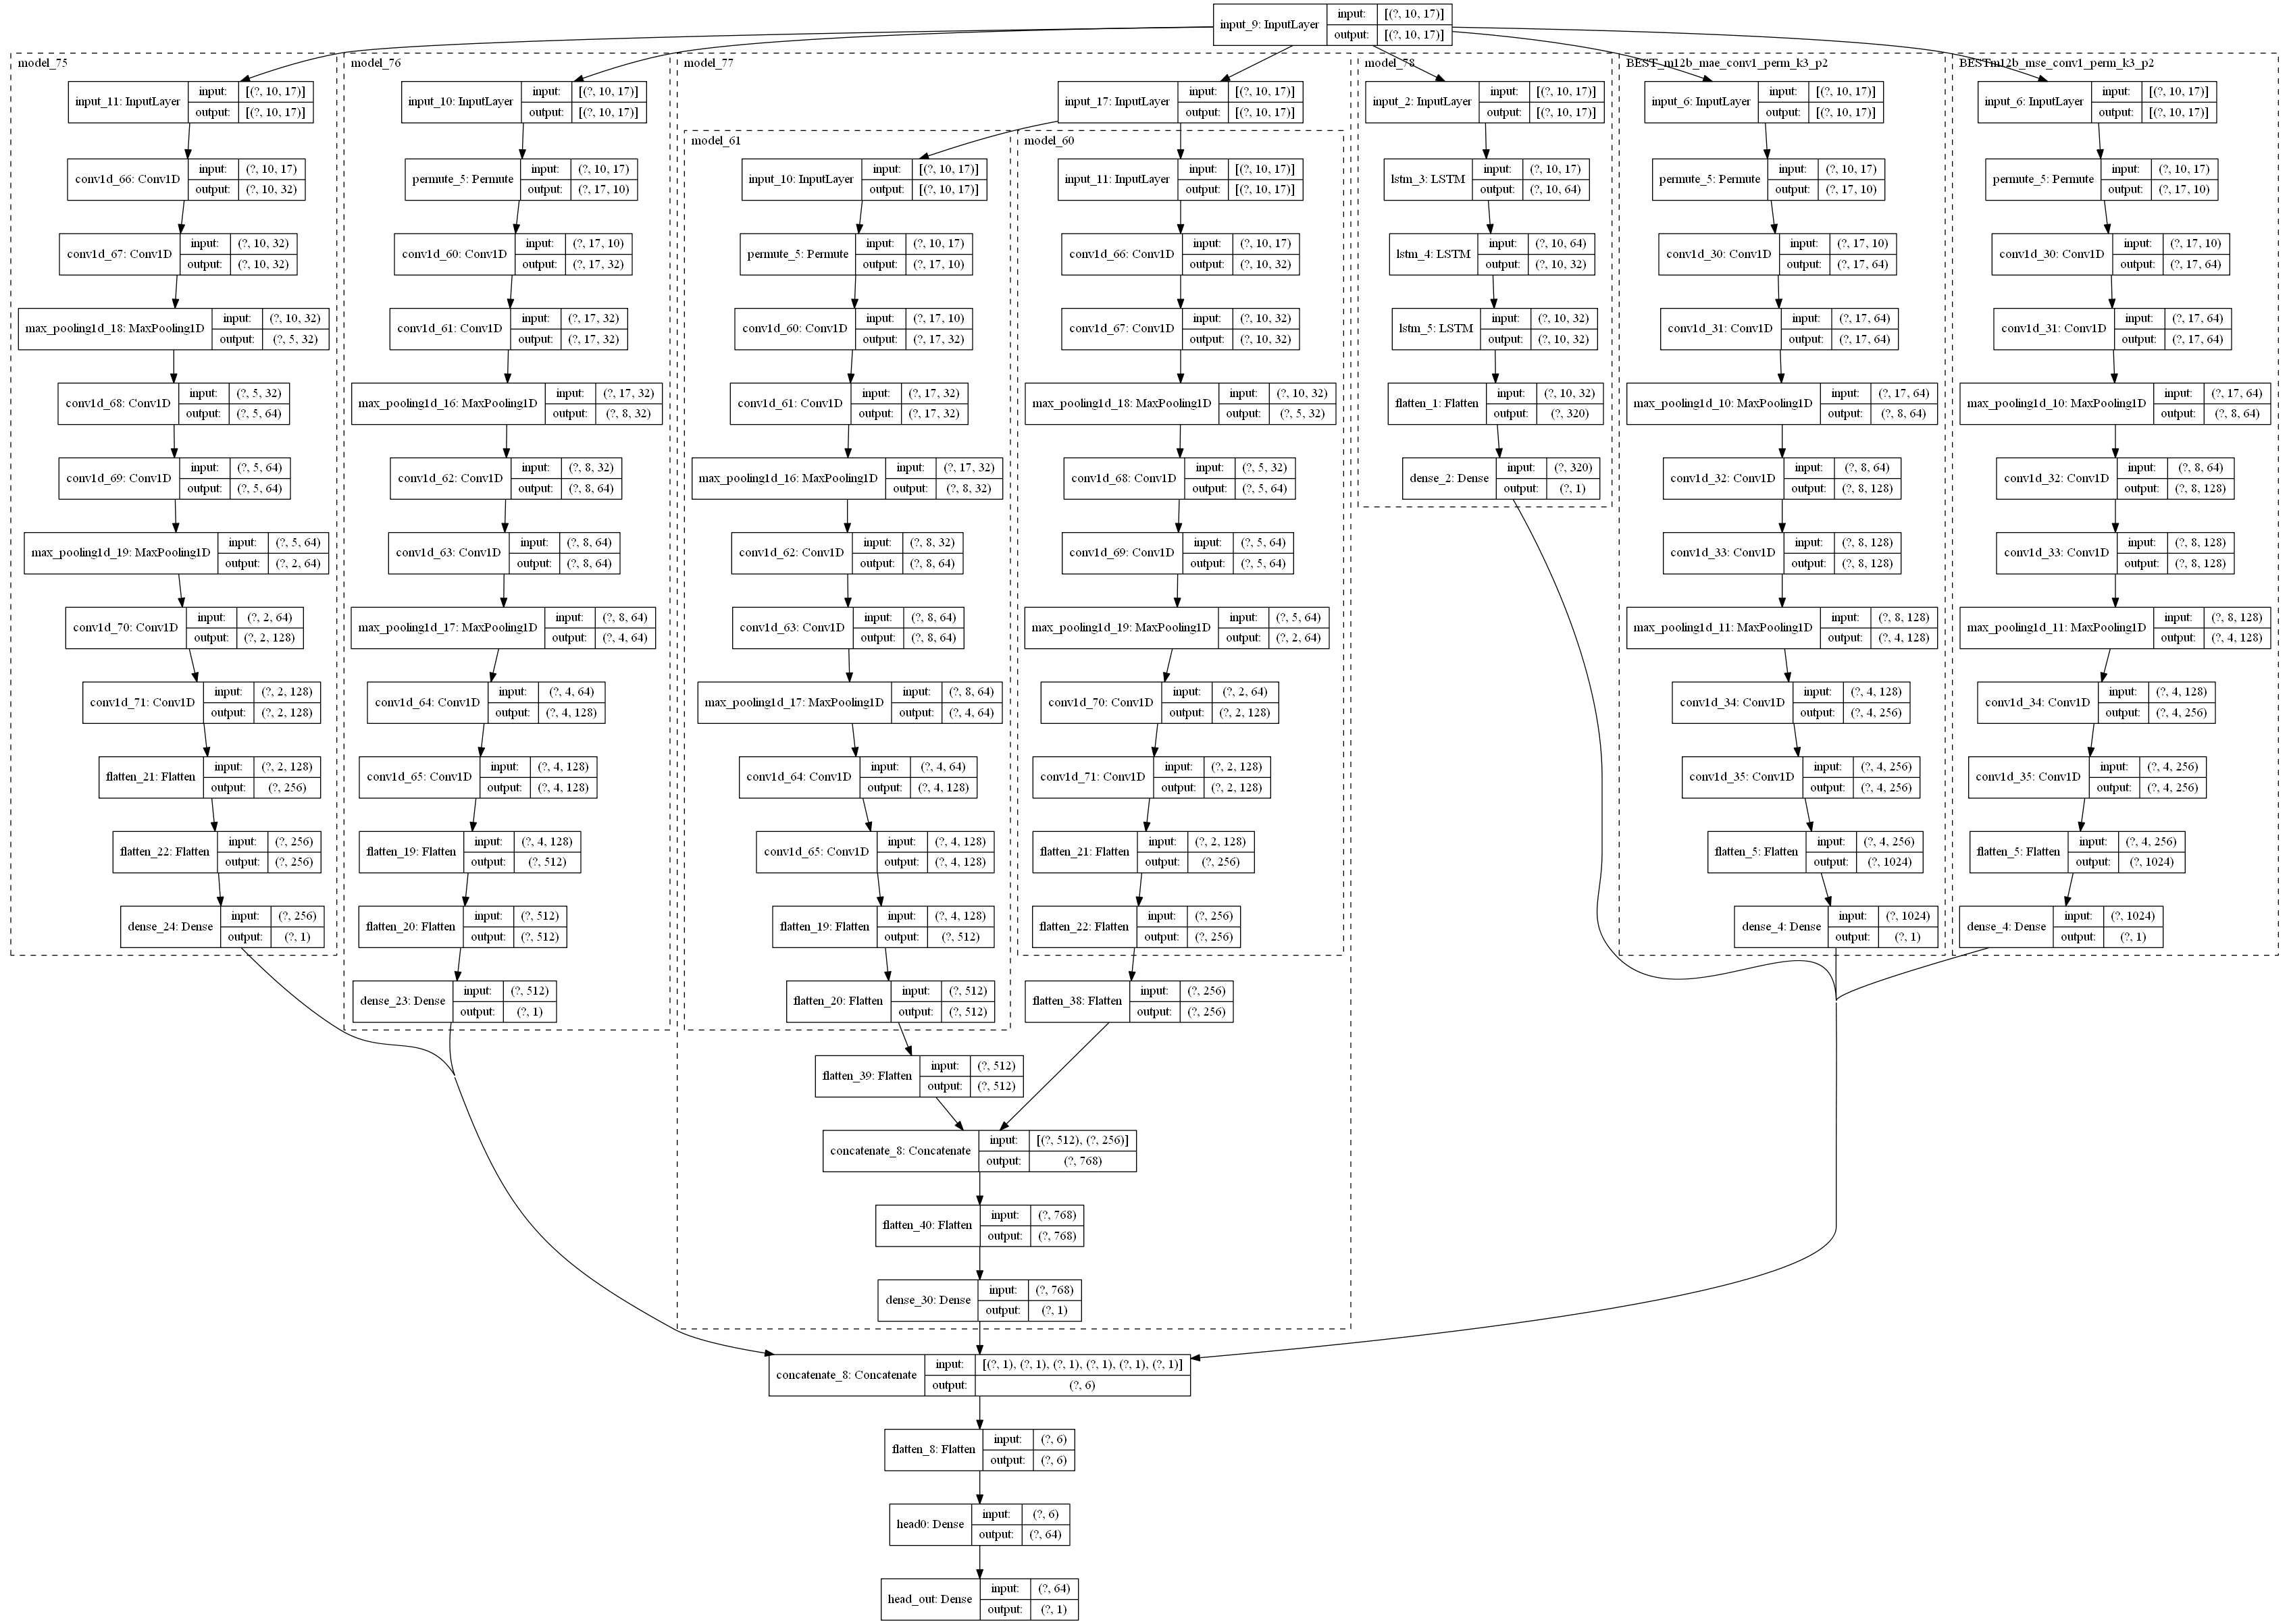

In [7]:
#downloading neural network

#R2 loss function
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


loss='mse'#mae or mse or R2. RMSE is square root by MSE
#loss=coeff_determination

optimiser=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

metric='mae'# mae or mse or R2

#loading model
model_json="pretrained_nn/best_mix.json"
model_h5="pretrained_nn/best_mix.h5"

json_file = open(model_json, "r")
loaded_model_json = json_file.read()
json_file.close()


model_loaded = model_from_json(loaded_model_json)
model_loaded.load_weights(model_h5)
print("Done")
model = Model(model_loaded.input, model_loaded.layers[-1].output)

model.summary()
model.compile(optimizer=optimiser, loss=loss, metrics=[metric])
plot_model(model, show_shapes=True, expand_nested=True)



In [8]:
#you can select results with different temperatures

#temperature diapason
min_val=0#minimum temperature
max_val=999#maximum temperature
#here wiil be results
write_it_into_file=True# if True results will be writed into processed_data/result.txt . File will not be cleaned



predicted = model.predict(fromulas_processed)
result_cs_writer=open('processed_data/result.txt', 'a', newline='')
result_writer = csv.writer(result_cs_writer, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)

if write_it_into_file==False:
    result_cs_writer.close() 
results=[]
for i in range(nums_custom_formulas):
    if predicted[i][0]<max_val and predicted[i][0]>min_val:
        print(rows[i][0]+" has critical temp "+str(predicted[i][0]))
        buf=[]
        buf.append(rows[i][0])
        buf.append(str(predicted[i][0]))
        results.append(buf)
        
        
if write_it_into_file==True:
    for i in range(nums_custom_formulas):
        result_writer.writerow(results[i])
        result_cs_writer.flush()
    
    result_cs_writer.close() 




H0.2He1.8Cu1O4 has critical temp 14.279649
Ba0.3La1.7Cu1O4 has critical temp 16.159319
Ba0.2La1.8Cu1O4 has critical temp 23.607737
Ba0.2O4Cu1La1.8 has critical temp 23.607737
Nd0.4Ba0.6Cu1O has critical temp 85.02821
Y1Ba2Cu3O7 has critical temp 86.62753
